In [32]:
import xml.etree.ElementTree as ET
tree = ET.parse('NEWS2018_DATASET_04/NEWS2018_M-EnHi_trn.xml')
root = tree.getroot()
root_child = list(root)
data = {'source':[],'target':[]}
for child in root_child:
    children = list(child)
    data['source'].append(children[0].text)
    data['target'].append(children[1].text)

In [33]:
import numpy as np
target = np.array(data['target'])
source = np.array(data['source'])

In [34]:
import tensorflow as tf
class Vector:
    def __init__(self, corpus):
        self.word2id = {}
        self.id2word = {}
        self.pad = "<PAD>"
        self.sos = "<SOS>"
        self.eos = "<EOS>"
        self.unk = "<UNK>"
        
        self.ipad = 0
        self.isos = 1
        self.ieos = 2
        self.iunk = 3
        
        self.word2id[self.pad] = 0
        self.word2id[self.sos] = 1
        self.word2id[self.eos] = 2
        self.word2id[self.unk] = 3
        
        self.id2word[0] = self.pad
        self.id2word[1] = self.sos
        self.id2word[2] = self.eos
        self.id2word[3] = self.unk
        
        curr_id = 4
        self.chars = {}
        self.max_len = 0
        for word in corpus:
            self.max_len = max(self.max_len, len(word))
            word = word.lower()
            for char in word.strip():
                self.chars[char] = 1 + self.chars.get(char,0)
        
        self.chars={k:v for k,v in sorted(self.chars.items(),
                key=lambda item:item[1], reverse=True)}
        for key in self.chars.keys():
            self.word2id[key] = curr_id
            self.id2word[curr_id] = key
            curr_id+=1
        self.vocab_size = len(self.word2id)
    
    def encode(self, word):
        word = word.lower().strip()
        res = [self.word2id.get(char,self.iunk) for char in word]
        res.insert(0,self.isos)
        res.append(self.ieos)
        res = res + [self.ipad for i in range(len(res), self.max_len+3)]
        return res[:self.max_len]
    
    def decode(self, vector):
        res = []
        for i in vector:
            if i in [0,1]:
                continue;
            if i == 2:
                break;
            res.append(self.id2word.get(i, self.unk))
        return ''.join(res)
        
        

In [35]:
hi = Vector(target)
en = Vector(source)

In [36]:
UNITS = 256

In [37]:
target = list(map(hi.encode, target))
source = list(map(en.encode, source))

In [38]:
target = tf.convert_to_tensor(np.array(target))
source = tf.convert_to_tensor(np.array(source))

In [39]:
BUFFER_SIZE = len(target)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((source[is_train], target[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((source[~is_train], target[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [40]:
def process_text(context, target):
    targ_in = target[:,:-1]
    targ_out = target[:,1:]
    return (context, targ_in), targ_out
  

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [41]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy())

[ 1  4 20  9  6  7 13 23  4  2]

[ 1 32 36  9 19 29  6 20  2  0]
[32 36  9 19 29  6 20  2  0  0]


In [42]:
class Encoder(tf.keras.layers.Layer):
      def __init__(self, vocab_size, units):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.units = units
        
        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.units,
                                                   mask_zero=True)
    
        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(self.units,
                                # Return the sequence and state
                                return_sequences=True,
                                recurrent_initializer='glorot_uniform'))
    
      def call(self, x):
        
    
        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        
        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        
        # 4. Returns the new sequence of embeddings.
        return x
    
      def convert_input(self, texts):
        texts = list(map(en.encode, texts))
        texts = tf.convert_to_tensor(np.array(texts))
        context = self(texts)
        return context
    

In [43]:
encoder = Encoder(en.vocab_size, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 61)
Encoder output, shape (batch, s, units): (64, 61, 256)


In [44]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        
        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)
        
        
        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores
    
        x = self.add([x, attn_output])
        x = self.layernorm(x)
    
        return x

In [45]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(hi.vocab_size,
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 61, 256)
Target sequence, shape (batch, t, units): (64, 61, 256)
Attention result, shape (batch, t, units): (64, 61, 256)
Attention weights, shape (batch, t, s):    (64, 61, 61)


In [46]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 0.99999994, 0.99999994, 0.99999994, 0.9999999 ,
       0.9999998 , 0.99999994, 1.        , 0.99999994, 0.99999976,
       0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976,
       0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976,
       0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976,
       0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976,
       0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976,
       0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976,
       0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976,
       0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976,
       0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976,
       0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976,
       0.99999976], dtype=float32)

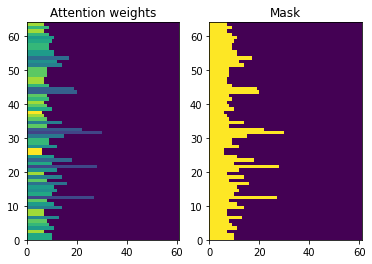

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [48]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, vocab_size, units):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.units = units
        self.start_token = 1
        self.end_token = 2
    
        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)
    
        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    
        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)
    
        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [49]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
    
    
    # 1. Lookup the embeddings
    x = self.embedding(x)
    
    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    
    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    
    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    
    if return_state:
        return logits, state
    else:
        return logits

In [50]:
decoder = Decoder(hi.vocab_size, UNITS)

In [51]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 61, 256)
input target tokens shape: (batch, t) (64, 61)
logits shape shape: (batch, target_vocabulary_size) (64, 61, 87)


In [52]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [53]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    tokens = tokens.numpy()
    words = [hi.decode(token) for token in tokens]
    return words

In [54]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
        context, next_token,
        state = state,
        return_state=True) 
  
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
    return next_token, done, state

In [55]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3]

['ष़ईक?झ-धण4', 'ज:गघ6कअकऑन', ')वढ ह:<UNK>ञग़']

In [56]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
               source_vocab_size,
               target_vocab_size):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(source_vocab_size, units)
        decoder = Decoder(target_vocab_size, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        #TODO(b/250038731): remove this
        try:
          # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [57]:
model = Translator(UNITS, en.vocab_size, hi.vocab_size)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 61)
Target tokens, shape: (batch, t) (64, 61)
logits, shape: (batch, t, target_vocabulary_size) (64, 61, 87)


In [32]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [33]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [35]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [30]:
vocab_size = 1.0 * hi.vocab_size

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 4.465908, 'expected_acc': 0.011494252873563218}

In [36]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 5s 69ms/step - loss: 0.2788 - masked_acc: 0.9109 - masked_loss: 0.2788


{'loss': 0.27882808446884155,
 'masked_acc': 0.910919189453125,
 'masked_loss': 0.27882808446884155}

In [32]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 26s 209ms/step - loss: 2.2784 - masked_acc: 0.3690 - masked_loss: 2.2784 - val_loss: 1.6135 - val_masked_acc: 0.5109 - val_masked_loss: 1.6135
Epoch 2/100
100/100 [==============================] - 21s 212ms/step - loss: 1.4105 - masked_acc: 0.5694 - masked_loss: 1.4096 - val_loss: 1.0982 - val_masked_acc: 0.6576 - val_masked_loss: 1.0982
Epoch 3/100
100/100 [==============================] - 21s 213ms/step - loss: 0.9566 - masked_acc: 0.7019 - masked_loss: 0.9566 - val_loss: 0.8858 - val_masked_acc: 0.7256 - val_masked_loss: 0.8858
Epoch 4/100
100/100 [==============================] - 22s 220ms/step - loss: 0.8220 - masked_acc: 0.7414 - masked_loss: 0.8227 - val_loss: 0.7717 - val_masked_acc: 0.7590 - val_masked_loss: 0.7717
Epoch 5/100
100/100 [==============================] - 22s 216ms/step - loss: 0.7333 - masked_acc: 0.7678 - masked_loss: 0.7345 - val_loss: 0.7008 - val_masked_acc: 0.7848 - val_masked_loss: 0.7008
Epoch 6/10

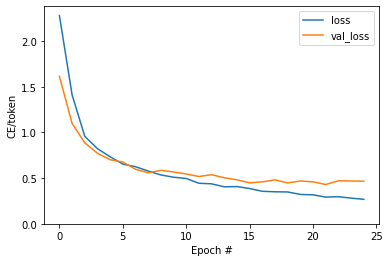

In [33]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

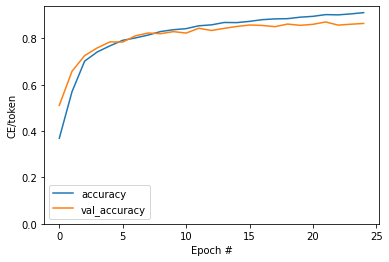

In [34]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [60]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)
        
        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)
    
        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [64]:
result = model.translate(['dukh', 'bahut bada dukh', 'jeevan ka dukh', 'dukh hi dukh']) # Are you still home
result

['दुख', 'बहुत बदा दुख', 'जीवन का दुख', 'दुख ही दुख']

In [65]:
model.save_weights('metadata/weights_2', save_format='tf')